# Selecting and tracking particles

This notebook explains how to select and track particles, with openPMD-viewer.

In this notebook:
- **selecting** means extracting the particles that satisfy a given set of criteria (e.g. in terms of energy or position) at a given iteration.
- **tracking** means selecting particles at one iteration, and then retrieving the same particles at another iterations.

**Note:** Tracking particles requires the particle ID to be stored in the openPMD files.

## (optional) Preparing this notebook to run it locally

If you choose to run this notebook on your local machine, you will need to download the openPMD data files which will then be visualized. To do so, and execute the following cell.

In [1]:
import os, sys, tarfile, wget

def download_if_absent( dataset_name ):
    "Function that downloads and decompress a chosen dataset"
    if os.path.exists( dataset_name ) is False:
        tar_name = "%s.tar.gz" %dataset_name
        url = "https://github.com/openPMD/openPMD-example-datasets/raw/draft/%s" %tar_name
        wget.download( url, tar_name )
        with tarfile.open( tar_name ) as tar_file:
            tar_file.extractall()
        os.remove( tar_name )

download_if_absent( 'example-2d' )

## Preparing the API

As usual, in order to use openPMD-viewer, we:
- load the class `OpenPMDTimeSeries` from the module `opmd_viewer`
- create a time series object by pointing to the folder which contains the corresponding openPMD data

In [2]:
from opmd_viewer import OpenPMDTimeSeries
ts = OpenPMDTimeSeries('./example-2d/hdf5/')

In addition, we import matplotlib and numpy, and we impose that the plots are incorporated inside the notebook.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Selecting particles that satisfy a set of conditions

In order to select particles according to a set of criteria, one needs to pass these criteria to the method `get_particle` as a dictionary, using the keyword argument `select`, as in the example below:

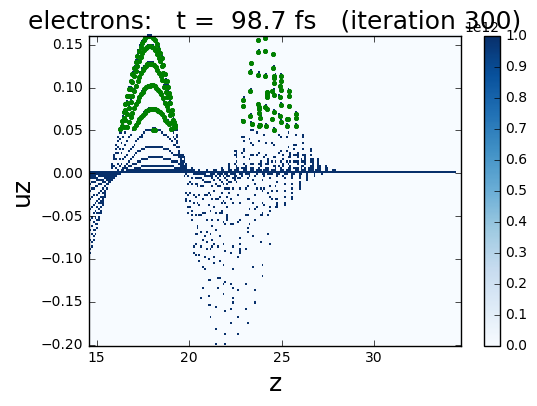

In [4]:
# Plot the blue phase space with all the electrons
ts.get_particle( ['z', 'uz'], species='electrons', iteration=300, plot=True, vmax=1e12 );

# Select only particles that have uz between 0.05 and 0.2 
# and plot them as green dots, on top of the phase space
z_selected, uz_selected = ts.get_particle( ['z', 'uz'], species='electrons', 
                            iteration=300, select={'uz':[0.05, 0.2]} )
plt.plot(z_selected, uz_selected, 'g.')

As can be seen from the example above, the format of the `select` dictionary is as follow:
- the key is a string which indicates a particle quantity
- the value is a list of two elements, which represent the bounds between which this quantity should be, for the particles to be retained.

Several criteria can be combined, by entering several key-value pairs in the `select` dictionary, as shown below:

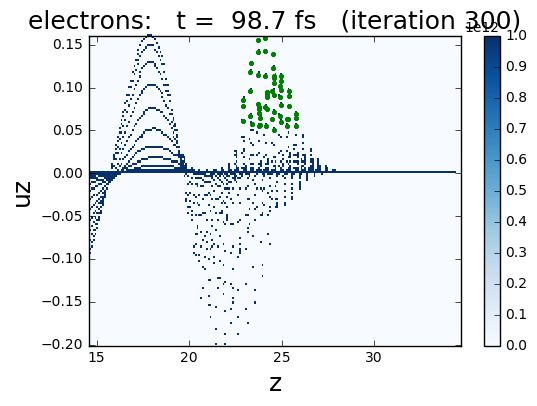

In [5]:
# Plot the blue phase space with all the electrons
ts.get_particle( ['z', 'uz'], species='electrons', iteration=300, plot=True, vmax=1e12 );

# Select only particles that have uz between 0.05 and 0.2 AND z between 22 and 26
# and plot them as green dots, on top of the phase space
z_selected, uz_selected = ts.get_particle( ['z', 'uz'], species='electrons', 
                            iteration=300, select={'uz':[0.05, 0.2], 'z':[22,26]} )
plt.plot(z_selected, uz_selected, 'g.')

## Tracking particles

While selecting particles only involves one iteration, tracking particles consist in:
- selecting particles at a given iteration
- retrieving the same particles at another iteration

The first step (selecting particles at a given iteration) is done by creating an instance of the `ParticleTracker` class.

In [6]:
from opmd_viewer import ParticleTracker
# Select particles to be tracked, at iteration 300
pt = ParticleTracker( ts, iteration=300, select={'uz':[0.05,0.2], 'z':[22,26]}, species='electrons' )

The second step (retrieving the same particles) is done by passing the `ParticleTracker` instance to the method `get_particle` as `select` (instead of a dictionary), as in the example below.

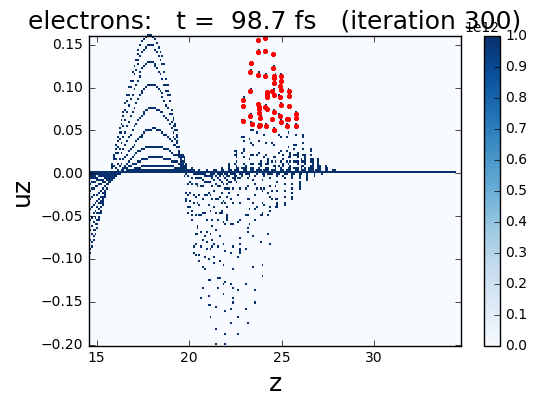

In [7]:
plot_iteration = 300

# Plot the blue phase space with all the electrons
ts.get_particle( ['z', 'uz'], species='electrons', iteration=plot_iteration, plot=True, vmax=1e12 );

# Plot the tracked particles as red dots, on top of the phase space
z_selected, uz_selected = ts.get_particle( ['z', 'uz'], species='electrons', iteration=plot_iteration, select=pt )
plt.plot(z_selected, uz_selected, 'r.')

The key point is that, when tracking particles, the iteration at which particles are retrieved can be different then the one at which they are selected, as in the example below:

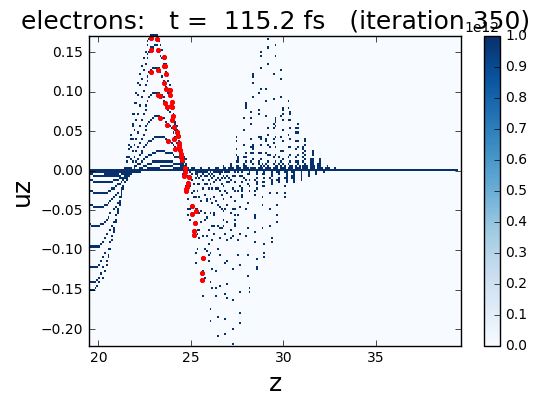

In [8]:
plot_iteration = 350

# Plot the blue phase space with all the electrons
ts.get_particle( ['z', 'uz'], species='electrons', iteration=plot_iteration, plot=True, vmax=1e12 );

# Plot the tracked particles as red dots, on top of the phase space
z_selected, uz_selected = ts.get_particle( ['z', 'uz'], species='electrons', iteration=plot_iteration, select=pt )
plt.plot(z_selected, uz_selected, 'r.')

## Reconstructing particle trajectories

Particle tracking can also be used in order to reconstruct individual particle trajectories, across several iterations.

However in order to do so, we need to be sure that, each time we retrieve particles (as arrays), the same individual particle is always at the same index of the array. This can be enabled with `ParticleTracker`, by using the argument `preserve_particle_index`.

In [9]:
pt = ParticleTracker( ts, iteration=300, select={'uz':[0.05,0.1], 'z':[22,26]}, 
                         species='electrons', preserve_particle_index=True )

Using this, we can now reconstruct a set of trajectories:

In [10]:
N_iterations = len(ts.iterations)
N_particles = pt.N_selected

uz_trajectories = np.empty( ( N_iterations, N_particles ) )
for i in range( N_iterations ):
    uz, = ts.get_particle( ['uz'], select=pt, iteration=ts.iterations[i], species='electrons' )
    uz_trajectories[i, :] = uz[:]

and plot the trajectories of a few particles (specifically those that are at index 0, 10 and 19).

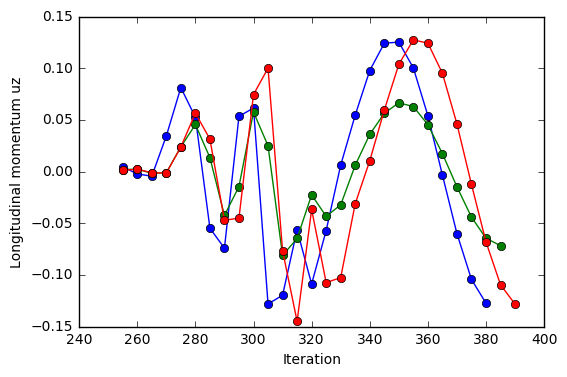

In [11]:
plt.plot( ts.iterations, uz_trajectories[:,0], '-o' )
plt.plot( ts.iterations, uz_trajectories[:,10], '-o' )
plt.plot( ts.iterations, uz_trajectories[:,19], '-o' )

plt.xlabel('Iteration')
plt.ylabel('Longitudinal momentum uz')